# Notebook with Face recognition (ArcFace)
© Реализовать ArcFace loss, обучить сеть с нуля на нем. Добиться accuracy на тестовой части >0.7.

## A few notes:

1. Initially, I spent a significant amount of time trying to train the network using the default parameters (s=64, m=0.5), but the loss did not decrease, and the metric did not improve. I even double-checked the implementation of the loss function multiple times. One artifact that remains from these experiments is the reduction in the number of neurons in the last layer of the feature extractor (from 1408 to 1024). As a result, the training is performed on a slightly modified version of EffNet-B2 rather than the full architecture. However, this modification might actually be beneficial. For the same reason, the data augmentation process is not as "aggressive" as in the baseline solution.

2. Around 10 runs (approximately 24 hours in total) were conducted in an attempt to find suitable parameters for the loss function. I won’t attach all the notebooks since they are nearly identical except for a few lines, but I am including graphs that provide some context and help justify the choice of parameters for this task (s=36, m=0.1).

3. Although ArcFake loss is a SOTA solution for face recognition tasks, the accuracy achieved in this case (~75%) is slightly lower than the baseline solution (~78%). I don’t see this as a significant issue because, as mentioned earlier, the last layer of the feature extractor was trimmed, and the accuracy metric is not the primary focus for the task of **constructing face embeddings**, where ArcFake loss is highly interpretable.

In [1]:
import random
import os
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from torch.nn.functional import normalize, one_hot
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torchvision.io import read_image

WORKING_DIR = '/kaggle/working'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)

Using device: cuda


In [2]:
def set_seed(seed):
    random.seed(seed)                      # Фиксация сидов для встроенного модуля random
    np.random.seed(seed)                   # Фиксация сидов для NumPy
    torch.manual_seed(seed)                # Фиксация сидов для PyTorch
    torch.cuda.manual_seed(seed)           # Фиксация сидов для CUDA
    torch.cuda.manual_seed_all(seed)       # Фиксация сидов для всех устройств CUDA
    torch.backends.cudnn.deterministic = True  # Обеспечивает детерминированное поведение CUDNN
    torch.backends.cudnn.benchmark = False     # Отключает эвристики CUDNN для детерминированности

set_seed(42)

## Download data from gdrive

In [3]:
# celebA_imgs.rar - An archive (a folder) with pictures
!gdown 1Anlz7R3KtyOwJB5ouVtELt1kU2QKNw1f
# celebA_train_split.txt - File with train/val/test split info 
!gdown 1tOKP0hmpaj7aMwOp6igZPuk2lBNxlwWK
# celebA_anno.txt - File with annotation - each picture from celebA_imgs is assigned its id
!gdown 1V3m3anz8gghYOLCYtlpQ1A6Qs1LKcBUB

Downloading...
From (original): https://drive.google.com/uc?id=1Anlz7R3KtyOwJB5ouVtELt1kU2QKNw1f
From (redirected): https://drive.google.com/uc?id=1Anlz7R3KtyOwJB5ouVtELt1kU2QKNw1f&confirm=t&uuid=c057a10f-4605-42cc-afd9-41715a334fa6
To: /kaggle/working/celebA_imgs.rar
100%|████████████████████████████████████████| 168M/168M [00:01<00:00, 92.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tOKP0hmpaj7aMwOp6igZPuk2lBNxlwWK
To: /kaggle/working/celebA_train_split.txt
100%|████████████████████████████████████████| 156k/156k [00:00<00:00, 59.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1V3m3anz8gghYOLCYtlpQ1A6Qs1LKcBUB
To: /kaggle/working/celebA_anno.txt
100%|████████████████████████████████████████| 177k/177k [00:00<00:00, 96.2MB/s]


In [4]:
# Package for unarchive
!pip install patool
import patoolib
patoolib.extract_archive(f"{WORKING_DIR}/celebA_imgs.rar", outdir="celebA_imgs")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 4.1 MB/s eta 0:00:00


INFO patool: Extracting /kaggle/working/celebA_imgs.rar ...
INFO patool: ... creating output directory `celebA_imgs'.
INFO patool: running /usr/bin/unrar x -kb -or -- /kaggle/working/celebA_imgs.rar
INFO patool: ... /kaggle/working/celebA_imgs.rar extracted to `celebA_imgs'.


'celebA_imgs'

## Parse input data

In [5]:
celeba_anno = pd.read_csv(f"{WORKING_DIR}/celebA_anno.txt", sep=" ", names=['path', 'id'])
celeba_train_split = pd.read_csv(f"{WORKING_DIR}/celebA_train_split.txt", sep=" ", names=['path', 'type'])

mapping = {0: 'train', 1: 'test', 2: 'val'}
celeba_train_split.replace({'type': mapping}, inplace=True)

celeba_train_split['type'].value_counts()

type
train    8544
test     1878
val      1589
Name: count, dtype: int64

In [6]:
def add_pathes(l, fill_to):
    total_len = len(l)
    if total_len < fill_to:
        l *= 1 + fill_to//total_len
        l = l[:fill_to]
    return l

def crop_image(image):
    """Custom advised crop"""
    image = image[:, 77:-41, 45:-50]
    return image

class CelebaImageDataset(Dataset):
    def __init__(
        self,
        annotations_file,
        img_dir,
        train_test_split_file=None,
        transform=None,
        target_transform=None
    ):
        self.img_labels = annotations_file
        self.img_dir = img_dir
        self.train_test_labels = train_test_split_file
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path).to(DEVICE)
        label = torch.tensor(self.img_labels.iloc[idx, 1]).to(DEVICE)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

    def get_sample_dataset(self, type_dataset):
        img_labels = self.img_labels
        train_test_labels = self.train_test_labels
        
        sample = img_labels.merge(train_test_labels, on='path', how='inner')
        sample = sample[sample['type'] == type_dataset]

        sample_dataset = CelebaImageDataset(
            annotations_file=sample,
            img_dir=self.img_dir,
            train_test_split_file=self.train_test_labels,
            transform=self.transform,
        )
        return sample_dataset

    def fill_train_data(self, fill_to):
        """
        Fill the (only train!) data in the dataset so that there are at least `fill_to` representatives of each class
        """
        grouped_img_labels = (
            self.img_labels
            .groupby('id')
            .agg(path=pd.NamedAgg(column="path", aggfunc=lambda x: x.tolist()))
            .reset_index()
        )
        grouped_img_labels['path'] = grouped_img_labels['path'].apply(lambda x: add_pathes(x, fill_to))
        exploded_grouped_img_labels = grouped_img_labels.explode('path', ignore_index=True)
        exploded_grouped_img_labels = exploded_grouped_img_labels.merge(self.train_test_labels, on='path', how='inner')
        self.img_labels = exploded_grouped_img_labels[['path', 'id', 'type']]

In [7]:
celeba_image_dataset = CelebaImageDataset(
    annotations_file=celeba_anno,
    img_dir=f"{WORKING_DIR}/celebA_imgs/celebA_imgs",
    train_test_split_file=celeba_train_split,
    transform=crop_image, 
)

train_image_dataset = celeba_image_dataset.get_sample_dataset(type_dataset='train')
test_image_dataset = celeba_image_dataset.get_sample_dataset(type_dataset='test')
val_image_dataset = celeba_image_dataset.get_sample_dataset(type_dataset='val')

# Fill train data up to 50 observations on each class (8544 -> 25000)
train_image_dataset_filled = deepcopy(train_image_dataset)
train_image_dataset_filled.fill_train_data(fill_to=50)

BATCH_SIZE = 64

train_dataloader = DataLoader(train_image_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_dataloader_filled = DataLoader(train_image_dataset_filled, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_image_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_image_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
def render_tensor(img, device):
    if str(device) == 'cuda':
        plt.imshow(torch.permute(img, (1, 2, 0)).cpu())
    else:
        plt.imshow(torch.permute(img, (1, 2, 0)))
    plt.axis('off')
    plt.show()
    return

Feature batch shape: torch.Size([64, 3, 100, 83])
Labels batch shape: torch.Size([64])
Label: 7


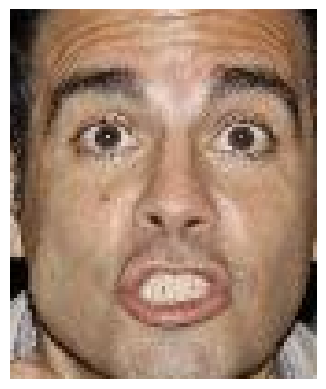

In [9]:
# Watching an image which fed into model
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]
label = train_labels[0]
print(f"Label: {label}")
render_tensor(img, DEVICE)

---

## ArcFaceLoss realization

In [10]:
class ArcFaceLoss(nn.Module):
    def __init__(self, s=64, m=0.5):
        super(ArcFaceLoss, self).__init__()
        self.margin = m
        self.scale = s
    
    def forward(self, weights, embeddings, targets):
        normalized_weights = normalize(weights).squeeze().type(torch.float64) # [classes x embedding_size]
        normalized_embeddings = normalize(embeddings).squeeze().type(torch.float64) # [batches x embedding_size]
        
        cosine_similarity = normalized_embeddings @ normalized_weights.T # [batches x classes]
        angle = torch.acos(cosine_similarity) # [batches x classes]
        # Осталось для каждого батча (= картинки, то есть для каждой строки) добавить margin в класс
        # (то есть в столбец), которому соответствует картинка (строка)
        one_hot_labels = one_hot(targets, num_classes=normalized_weights.size(0)) # [batches x classes]

        # Добавим margin и scale
        angle_margin = angle + self.margin * one_hot_labels  # [batches x classes]
        coses = torch.cos(angle_margin) # [batches x classes]
        scaled_coses = self.scale * coses # [batches x classes]
        
        numerator = torch.exp(scaled_coses) * one_hot_labels # [batches x classes]
        numerator_s = numerator.sum(dim=1) # [batches]
        
        denominator = torch.exp(scaled_coses) # [batches x classes]
        denominator_s = denominator.sum(dim=1) # [batches]

        loss = numerator_s / (denominator_s + 1e-16)
        loss_s = -torch.log(loss + 1e-16).mean()
            
        return loss_s

## Load model

In [11]:
class EfficientNet2(nn.Module):
    def __init__(self, pretrained=False, num_classes=500):
        super(EfficientNet2, self).__init__()
        self.model = models.efficientnet_b2(weights=pretrained)

        embedding_size = 1024
        
        # Change embedding size
        self.model.features[8] = nn.Sequential(
            # 352 = self.model.features[8].Conv2d.in_features but not sure
            nn.Conv2d(352, embedding_size, kernel_size=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(embedding_size, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.SiLU(inplace=True)
        )
        
        # Change out_features of last FC-layer
        self.model.classifier[1] = nn.Linear(embedding_size, num_classes, bias=False)
    
    def forward(self, x):
        embeddings = self.model.avgpool(self.model.features(x))
        embeddings = embeddings.squeeze()
        output = self.model.classifier(embeddings)
        last_layer_weight = self.model.classifier[1].weight

        return output, embeddings, last_layer_weight

In [12]:
display(len(train_dataloader.dataset))
display(len(train_dataloader_filled.dataset))

8544

25000

## Train model

In [13]:
def custom_norm(x):
    return x/255

normalize_transformer = transforms.Compose([
        custom_norm,
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.Resize((224, 224)),
    ])

augment_n_normalize_transformer = transforms.Compose([
        # augmentations
        transforms.RandomHorizontalFlip(),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.35),
        transforms.RandomAdjustSharpness(sharpness_factor=0.5, p=0.35),
        transforms.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.5, hue=0.12),
        transforms.RandomRotation(degrees=(-6, 6)),
        transforms.RandomAffine(degrees=0, scale=(0.9, 1.1)),
        # normalizations
        normalize_transformer
    ])

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = augment_n_normalize_transformer(X)
        pred, embeddings, weights = model(X)
        if isinstance(loss_fn, nn.CrossEntropyLoss):
            loss = loss_fn(embeddings @ weights.T, y)
        elif (isinstance(loss_fn, ArcFaceLoss)):
            loss = loss_fn(weights=weights, embeddings=embeddings, targets=y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def test_loop(dataloader, model, loss_fn, prefix):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = normalize_transformer(X)
            pred, embeddings, weights = model(X)
            if isinstance(loss_fn, nn.CrossEntropyLoss):
                loss = loss_fn(embeddings @ weights.T, y)
            elif (isinstance(loss_fn, ArcFaceLoss)):
                loss = loss_fn(weights=weights, embeddings=embeddings, targets=y)
            test_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test-{prefix} Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")

    return correct, test_loss

In [14]:
def train_model(model, train_dataloader, test_dataloader, val_dataloader, loss_fn, optimizer, epochs):
    train_losses = []; test_losses = []; val_losses = [];
    train_accs = []; test_accs = []; val_accs = [];

    for t in range(epochs):
        print(f"__________ Epoch {t+1} __________")
        train_loop(train_dataloader_filled, efnet2, loss_fn, optimizer)
        train_acc, train_loss = test_loop(train_dataloader, efnet2, loss_fn, prefix='train')
        test_acc, test_loss = test_loop(test_dataloader, efnet2, loss_fn, prefix='test')
        val_acc, val_loss = test_loop(val_dataloader, efnet2, loss_fn, prefix='val')
        
        train_losses.append(train_loss); test_losses.append(test_loss); val_losses.append(val_loss)
        train_accs.append(train_acc); test_accs.append(test_acc); val_accs.append(val_acc)
        print()

    metrics = {
        'losses': {
            'train': train_losses,
            'test': test_losses,
            'val': val_losses},
        'accs': {
            'train': train_accs,
            'test': test_accs,
            'val': val_accs}
    }
    
    return metrics


---

In [15]:
learning_rate = 5e-3
epochs = 46

In [16]:
efnet2 = EfficientNet2(pretrained=False).to(DEVICE)
optimizer = torch.optim.AdamW(efnet2.parameters(), lr=learning_rate)
history = train_model(efnet2, train_dataloader, test_dataloader, val_dataloader, ArcFaceLoss(s=36, m=0.12), optimizer, epochs)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


__________ Epoch 1 __________
Test-train Error: 
 Accuracy: 0.2%, Avg loss: 10.773219
Test-test Error: 
 Accuracy: 0.2%, Avg loss: 10.781760
Test-val Error: 
 Accuracy: 0.2%, Avg loss: 10.769551

__________ Epoch 2 __________
Test-train Error: 
 Accuracy: 0.3%, Avg loss: 10.491445
Test-test Error: 
 Accuracy: 0.3%, Avg loss: 10.527203
Test-val Error: 
 Accuracy: 0.2%, Avg loss: 10.533423

__________ Epoch 3 __________
Test-train Error: 
 Accuracy: 0.3%, Avg loss: 10.415389
Test-test Error: 
 Accuracy: 0.2%, Avg loss: 10.454861
Test-val Error: 
 Accuracy: 0.3%, Avg loss: 10.454787

__________ Epoch 4 __________
Test-train Error: 
 Accuracy: 0.9%, Avg loss: 10.414036
Test-test Error: 
 Accuracy: 1.0%, Avg loss: 10.492519
Test-val Error: 
 Accuracy: 0.8%, Avg loss: 10.537020

__________ Epoch 5 __________
Test-train Error: 
 Accuracy: 2.1%, Avg loss: 9.797352
Test-test Error: 
 Accuracy: 1.5%, Avg loss: 9.979710
Test-val Error: 
 Accuracy: 1.8%, Avg loss: 10.005418

__________ Epoch 6 ___

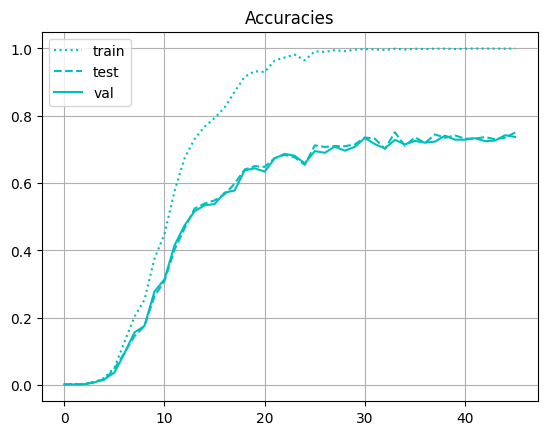

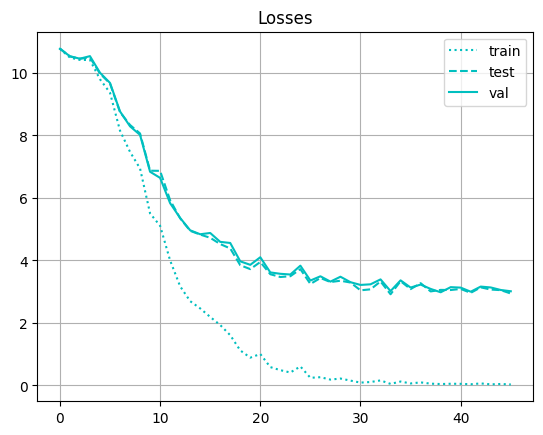

In [17]:
plt.title('Accuracies')

plt.plot(range(epochs), history['accs']['train'], label='train', linestyle='dotted', color='c')
plt.plot(range(epochs), history['accs']['test'], label='test', linestyle='dashed', color='c')
plt.plot(range(epochs), history['accs']['val'], label='val', linestyle='solid', color='c')

plt.grid()
plt.legend()
plt.show()

plt.title('Losses')

plt.plot(range(epochs), history['losses']['train'], label='train', linestyle='dotted', color='c')
plt.plot(range(epochs), history['losses']['test'], label='test', linestyle='dashed', color='c')
plt.plot(range(epochs), history['losses']['val'], label='val', linestyle='solid', color='c')

plt.grid()
plt.legend()
plt.show()

In [18]:
torch.save(efnet2.state_dict(), f"./arcface_trained_efnet2.pt")